# <h1><center> Moana thredds server connector </center></h1>

Author: Sebastien Delaux

This notebook describes how to get observation data from the thredds server set on top of the Moana 25 year hydrodynamic hindcast of New Zealand waters. The data is freely available from that server under the terms of the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License (see https://www.moanaproject.org/data for more).

## Data description

The Moana backbone hindcast datasets comes in the form of 4 sources of data stored in 4 subfolders on the thredds server (http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/catalog.xml):

- __raw_3D__: This folder contains the raw ROMS outputs (3D and 2D fields). All the fields are laid on their original curvilinear grids. Main variables are:

    * Free-surface height (zeta) in metres
    * Eastward vertically integrated momentum component (ubar_eastward) in metres per second
    * Northward vertically integrated momentum component (vbar_eastward) in metres per second
    * Eastward momentum component (u_eastward) in metres per second
    * Northward momentum component (v_eastward) in metres per second
    * Potential temperature (temp) in degrees Celcius
    * Salinity (salt)

  _cat_url_ = 'http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/raw_3D/catalog.xml' <br>
  _base_dods_url_ = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/raw_3D/' <br>
  

- __monthly_avg__: This folder contains monthly averages of the raw ROMS outputs (3D and 2D fields). Main variables are:
    * Time-averaged free-surface height (zeta) in metres
    * Time-averaged eastward vertically integrated momentum component (ubar_eastward) in metres per second
    * Time-averaged northward vertically integrated momentum component (vbar_eastward) in metres per second
    * Time-averaged eastward momentum component (u_eastward) in metres per second
    * Time-averaged northward momentum component (v_eastward) in metres per second
    * Time-averaged potential temperature (temp) in degrees Celcius
    * Time-averaged salinity (salt)

  _cat_url_ = 'http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/monthly_avg/catalog.xml' <br>
  _base_dods_url_ = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/monthly_avg/' <br>
  

- __processed_sfc__: This folder contains 2D variables only (surface, depth-averaged, bathymetry) interpolated to a rectilinear longitude/latitude grid. Main variables are:
    * Sea surface height above geoid (ssh) in metres
    * Sea surface temperature (sst) in degrees Celcius
    * Surface Eastward sea water velocity (us) in metres per second
    * Surface Northward sea water velocity (vs) in metres per second
    * Depth-averaged Eastward sea water velocity (um) in metres per second
    * Depth-averaged Northward sea water velocity (vm) in metres per second
    * Sea floor depth below mean sea level (dep) in metres
    
  _cat_url_ = http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/processed_sfc/catalog.xml' <br>
  _base_dods_url_ = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/processed_sfc/' <br>
  
  
- __processed_3D__: This folder contains the 3D fields interpolated on a rectilinear longitude/latitude/level 3D grids. Main variables are:
    * Sea water temperature (temp) in degrees Celcius
    * Sea water absolute salinity (salt) in 1e-3
    * Eastward sea water velocity (u) in metres per second
    * Northward sea water velocity (v) in meters per second
    
  _cat_url_ = 'http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/processed_3D/catalog.xml' <br>
  _base_dods_url_ = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/processed_3D/' <br>

## Connector description
For now the connector provides only a way to load the data under the shape of an xarray dataset.

The motivation being using xarray are the following:
- xarray is a popular python library that allow to work with NetCDF files stored on drive or on openDap servers
- xarray is built on top of dask which allow a number of operations, in particular sub-sampling, to be done in lazy mode (data don't get loaded until really needed)
- xarray is highly compatible with the numpy library
- xarray offers a number of useful export/plotting functions

## Connector
First we install xarray which we will use to handle the data and siphon which we will use to talk with the thredds server catalog. Also we install matplotlib to generate plots later on.

In [1]:
import sys
!{sys.executable} -m pip install xarray siphon matplotlib

    100% |████████████████████████████████| 675kB 1.2MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/56/f5/2be03af9ac2911d4795ac69de86dbd1b48c404a7812a4bf1b00403eafda5/siphon-0.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/4b/52da6b1523d5139d04e02d9e26ceda6146b48f2a4e5d2abfdf1c7bac8c40/matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/07/08/a549ba8b061005bb629b76adc000f3caaaf881028b963c2e18f811c6edc1/numpy-1.18.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a0/df/635cdb901ee4a8a42ec68e480c49f85f4c59e8816effbf57d9e6ee8b3588/setuptools-46.1.3-py3-none-any.whl
    100% |████████████████████████████████| 10.0MB 175kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1a/70/1935c770cb3be6e3a8b78ced23d7e0f3b187f5cbfab4749523ed65d7c9b1/requests-2.23.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/pac

Now we load xarray and siphon

In [2]:
import xarray as xr
from siphon.catalog import TDSCatalog

Then we load a couple of reasonably standard python library

In [3]:
import numpy
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools
import re

We define a couple of methods helping to identify whether a filename contains data relevant to a given time range. Those allow to avoid loading unnecessary metadata.

In [4]:
def datetime_from_filename(filename):
    """
        Parse a moana filename and return the datetime corresponding
        to the first timestamp in the monthly file
        
        Parameters
        ----------
        filename : str
            The name of one of the Moana netCDF files from the thredds server.
            
        Returns
        -------
        datetime
            A datetime object corresponding to the first timestamp in the file
        
        """
    datestring = re.search('(20\d{2}\d{2}|19\d{2}\d{2})', filename).group()
    return datetime.strptime(datestring, '%Y%m')

def monthly_file_in_interval(filename, tmin=None, tmax=None):
    """
        Check whether a monthly Moana file contains data relevant to the time
        range [t1:t2]
        
        Parameters
        ----------
        filename : str
            The name of one of the Moana netCDF files from the thredds server.
        
        t1 : datetime
            The start of the time range (None for an open interval). The start
            datetime is inclusive
        
        t2 : datetime
            The end of the time range (None for an open interval). The end
            datetime is exclusive
            
        Returns
        -------
        boolean
            Whether the file data relevant to the time range [t1:t2]
        
        """
    if tmin is None and tmax is None:
        return True
    
    t1 = datetime_from_filename(filename)
    
    if tmin is None:
        return t1 < tmax
    
    if tmax is None:
        return tmin < t1 + relativedelta(months=1)
    
    return t1 < tmax and tmin < t1 + relativedelta(months=1)

We define the connector

In [5]:
class MoanaThreddsServerConnector(object):
    """
    A class used to connect one the thredds server put
    on top of the Moana hydrodynamic hindcast of New Zealand waters
    
    Attributes
    ----------
    catalog_url : str
        The url to use to interogate the data catalog
    dods_base_url : str
        The base url to use to access the data via OpenDAP
    tmin : datetime
        The lower end of the time range for which data are required (inclusive).
        None means an open ended interval
    tmax : datetime
        The upper end of the time range for which data are required (exclusive).
        None means an open ended interval
        
    Methods
    -------
    get_xarray_dataset()
        return a xarray dataset object that allows efficient access/subsampling
        of the data
    """
    def __init__(self,
                 catalog_url='http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/monthly_avg/catalog.xml',
                 dods_base_url='http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/monthly_avg/',
                 tmin=None,
                 tmax=None):
        
        
        # Store the urls
        self.catalog_url = catalog_url
        self.dods_base_url = dods_base_url
        
        # Get catalog
        self.catalog = TDSCatalog(catalog_url)
        
        # Build list of all available files
        self.dods_url = [dods_base_url+filename\
                         for filename in sorted(self.catalog.datasets)
                         if monthly_file_in_interval(filename, tmin=tmin, tmax=tmax)]
        
        # Load base dataset object
        if 'processed' in catalog_url:
            concat_dim = 'time'
        else:
            concat_dim = 'ocean_time'
            
        self.dset = xr.open_mfdataset(self.dods_url,
                                      parallel=True,
                                      coords="minimal",
                                      data_vars="minimal",
                                      compat='override',
                                      combine='nested',
                                      concat_dim=concat_dim)
                                      
    def get_xarray_dset(self):
        return self.dset

## Example usage of connector
Initialise the connector

In [6]:
cat_url = "http://thredds.moanaproject.org:8080/thredds/catalog/moana/ocean/NZB/v1.9/monthly_avg/catalog.xml"
base_dods_url = 'http://thredds.moanaproject.org:8080/thredds/dodsC/moana/ocean/NZB/v1.9/monthly_avg/'

connector = MoanaThreddsServerConnector(cat_url, base_dods_url, tmin=datetime(2017,1,1), tmax=datetime(2017,4,1))

For now get the full xarray dataset object

In [7]:
dset = connector.get_xarray_dset()

Find the names of all the variables in the datasets that are time dependent

In [8]:
for (var_name, var) in dset.data_vars.items():
    if 'ocean_time' in var.dims and len(var.dims)>1:
        print(var_name, '-->', var.attrs['long_name'],var.dims)

zeta --> time-averaged free-surface ('ocean_time', 'eta_rho', 'xi_rho')
ubar_eastward --> time-averaged eastward vertically integrated momentum component at RHO-points ('ocean_time', 'eta_rho', 'xi_rho')
vbar_northward --> time-averaged northward vertically integrated momentum component at RHO-points ('ocean_time', 'eta_rho', 'xi_rho')
u_eastward --> time-averaged eastward momentum component at RHO-points ('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
v_northward --> time-averaged northward momentum component at RHO-points ('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
temp --> time-averaged potential temperature ('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
salt --> time-averaged salinity ('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


In [9]:
print("The dataset contains data from",
      dset.variables['ocean_time'].data[0],
      "to",
      dset.variables['ocean_time'].data[-1])

The dataset contains data from 2017-01-01T12:00:00.000000000 to 2017-03-31T12:00:00.000000000


Now lets load some data. Lets say we want temperature data.
The corresponding variable for time-averaged potential temperature is named 'temp'
The dimensions and shape of the array are the following

In [10]:
print("Shape of 'temp' variable is ", dset.variables['temp'].shape)
print("Dimensions are ", dset.variables['temp'].dims)

Shape of 'temp' variable is  (90, 40, 467, 397)
Dimensions are  ('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


The variable has 4 dimension in order time/level/2 dimensions of space.
We load the data every 10 time-stamp for the level the closest to the surface (last one) and over the whole simulation domain.

In [11]:
temp_data = dset.variables['temp'][::10,-1,:,:].load()

Now lets plot the data. We plot the 6 consecutive frames in a 2x3 array.

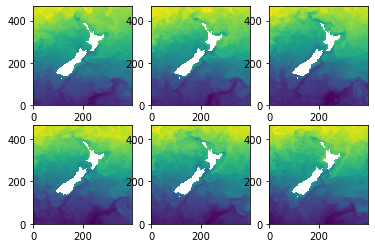

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 3)

for ax, data in zip(axs.flat, temp_data):
    ax.pcolor(data)

Now lets get a time-series of time-averaged elevation at a specific location. The corresponding variable is named zeta and has 3 dimensions (one of time and 2 of space)

In [13]:
zeta_data = dset.variables['zeta'][:,300,100].load()

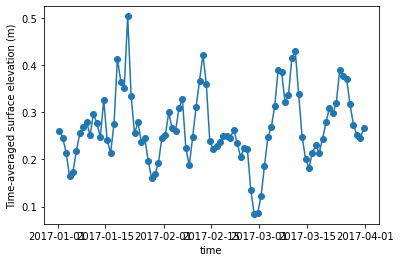

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

plt.xlabel('time')
plt.ylabel('Time-averaged surface elevation (m)')
plt.plot_date(date2num(dset.ocean_time), zeta_data, linestyle='-')

More to come on how to get data for a specific bounding box or point defined using WGS84 longitudes and latitudes.
Also, more data will be uploaded to the server which will be described.

None lets plot a cross section of the data.
First we select a cross section of the 3D grid for the first timestamp of the dataset.

In [15]:
ds = dset.isel(ocean_time=0,xi_rho=200)

It can be plot using the s coordinate as the vertical dimension which does not show the actual depth of the cross-section.

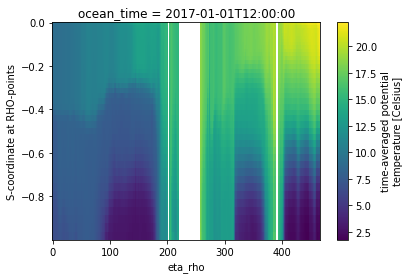

In [16]:
ds.temp.plot()

Following (http://xarray.pydata.org/en/stable/examples/ROMS_ocean_model.html) we can write the equations to calculate the vertical coordinate

In [17]:
if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    
ds.coords['z_rho'] = z_rho.fillna(0).transpose()# needing transpose seems to be an xarray bug

Now the plot can be redone using the depth and the latitudes as coordinates

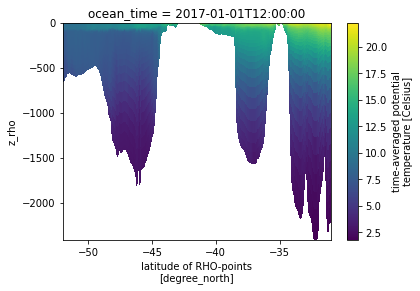

In [18]:
ds.temp.plot(x='lat_rho', y='z_rho')